collecting undefined pixels


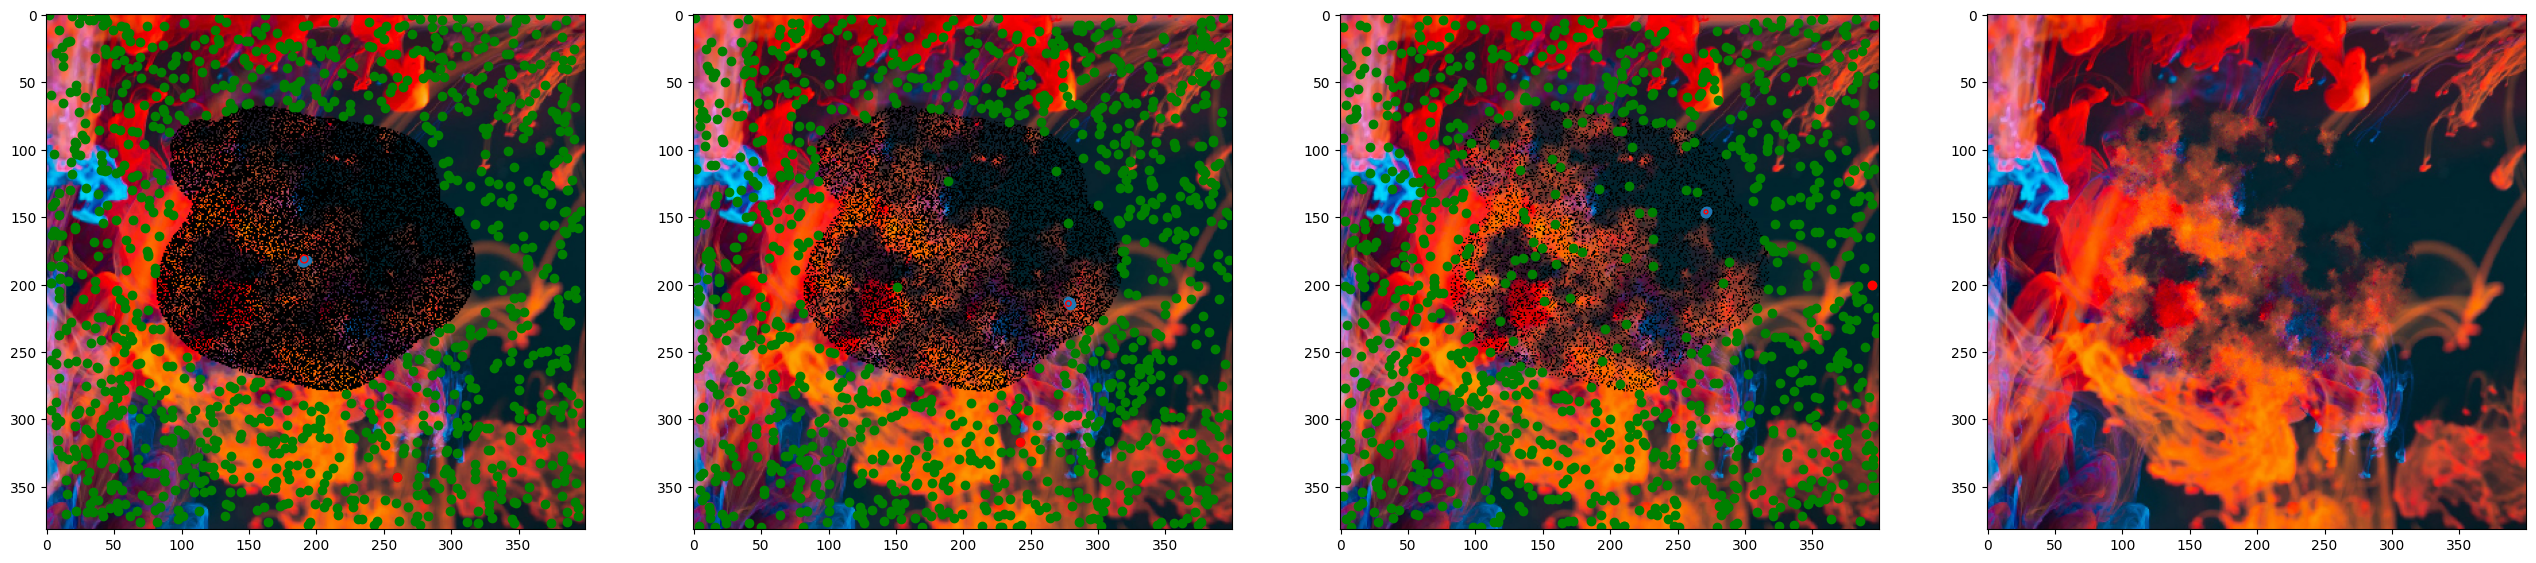

In [17]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy
import math
import random

defined      = 0
undefined    = 255

def l2_distance( x0, y0, x1, y1 ):
    dx = x0 - x1
    dy = y0 - y1
    return math.sqrt( dx*dx + dy*dy )     

def get_defined_pixels_in_range( origin_x, origin_y, x0, y0, x1, y1, mask ):
    candidates = []
    for y in range(y0, y1):
        for x in range(x0, x1):
            if mask[y,x] != undefined:
                distance = l2_distance(origin_x, origin_y, x, y)
                candidates.append( (x,y,distance) )
    return candidates

def iterate_all_sides( x_origin, y_origin, rect_half_size, mask ):
    candidates = []
    candidates = candidates + get_defined_pixels_in_range( x_origin, y_origin, x_origin-rect_half_size, y_origin-rect_half_size,   x_origin+rect_half_size+1, y_origin-rect_half_size+1, mask )
    candidates = candidates + get_defined_pixels_in_range( x_origin, y_origin, x_origin+rect_half_size, y_origin-rect_half_size+1, x_origin+rect_half_size+1, y_origin+rect_half_size  , mask )
    candidates = candidates + get_defined_pixels_in_range( x_origin, y_origin, x_origin-rect_half_size, y_origin+rect_half_size,   x_origin+rect_half_size+1, y_origin+rect_half_size+1, mask )
    candidates = candidates + get_defined_pixels_in_range( x_origin, y_origin, x_origin-rect_half_size, y_origin-rect_half_size+1, x_origin-rect_half_size+1, y_origin+rect_half_size  , mask )
    return candidates

def find_nearest_neighbors_bfs_rect( coordinate, mask, k ):
    x_origin,y_origin = coordinate
    candidates = []
    rect_half_size = 1
    while True:
        candidates = candidates + iterate_all_sides( x_origin, y_origin, rect_half_size, mask )
        candidates = sorted( candidates, key=lambda x: x[2] )
        candidates = candidates[0:k]
        if len(candidates) == k:
            _,_,best_kth_distance = candidates[-1]
            if best_kth_distance < rect_half_size:
                return candidates     
        rect_half_size = rect_half_size + 1
    return None

def create_pattern( coordinate, mask, k ):
    x_origin,y_origin = coordinate
    pattern = []
    neighbors = find_nearest_neighbors_bfs_rect( coordinate, mask, k )
    for x,y,_ in neighbors:
        pattern.append( ( x-x_origin, y-y_origin ) )
    return pattern

def candidate_is_valid( origin_x, origin_y, mask, pattern ):
    if mask[origin_y,origin_x] == undefined:
        return False
    for x,y in pattern:
        if origin_x+x<0 or origin_y+y<0:
            return False
        if origin_x+x>=mask.shape[1] or origin_y+y>=mask.shape[0]:
            return False
        if mask[origin_y+y,origin_x+x] == undefined:
            return False
    return True

def suggest_random_candidates( mask, pattern, n ):
    candidates = []
    while len(candidates) < n:
        origin_x = int( random.uniform( 0, mask.shape[1] ) )
        origin_y = int( random.uniform( 0, mask.shape[0] ) )
        if candidate_is_valid( origin_x, origin_y, mask, pattern ):
            candidates.append( (origin_x,origin_y) ) 
    return candidates

def suggest_candidates( mask, pattern, n ):
    return suggest_random_candidates(  mask, pattern, n )

def sparse_l2_cost( origin, candidate, image, pattern ):
    cost_sum = 0.0
    ox,oy = origin
    cx,cy = candidate
    for dx,dy in pattern:
        color0 = image[oy+dy,ox+dx]
        color1 = image[cy+dy,cx+dx]
        for channel in range(color0.shape[0]):
            distance_per_channel = float( color0[channel] ) - float( color1[channel] )
            cost_sum += distance_per_channel*distance_per_channel
    return math.sqrt( cost_sum )
    
def evaluate_candidates( image, origin, candidates, pattern ):
    result = []
    for candidate_x, candidate_y in candidates:
        distance = sparse_l2_cost( origin, (candidate_x, candidate_y), image, pattern )
        result.append( (candidate_x, candidate_y,distance) )
    result = sorted( result, key=lambda x: x[2] )
    return result

def perform_inpainting_step( image, mask, origin, candidates_to_consider ):
    pattern = create_pattern( origin, mask, 5 ) 
    candidates = suggest_candidates( mask, pattern, candidates_to_consider )
    candidates = evaluate_candidates( image, origin, candidates, pattern )
    cx,cy,_ = candidates[0]
    ox,oy   = origin
    image[oy,ox,:] = image[cy,cx,:]
    mask[oy,ox] = defined
    return pattern,candidates,origin

def collect_undefined_pixels( mask ):
    undefined_pixels = []
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y,x] == undefined:
                undefined_pixels.append((x,y))   
    return undefined_pixels

def perform_inpainting( image, mask, undefined_pixels, steps, candidates_to_consider=100 ):
    if steps>len(undefined_pixels):
        steps = len(undefined_pixels)
    for i in range(steps):
        origin = random.choice( undefined_pixels )
        undefined_pixels.remove( origin )
        perform_inpainting_step( image, mask, origin, candidates_to_consider )

def display_pattern( axis, mask, origin, pattern ):
    ox,oy = origin
    # axis.imshow(mask, cmap='Greys', alpha=0.5)
    X = [ox+x for x,_ in pattern ]
    Y = [oy+y for _,y in pattern ]
    ox,oy = origin
    axis.scatter( x=[ox],y=[oy], c="red" )
    axis.scatter( x=X,y=Y )
    knn_x,knn_y = pattern[-1]
    r = l2_distance(0,0,knn_x,knn_y)
    axis.add_patch( plt.Circle(origin, radius=r, edgecolor="red", facecolor="None" ) )
    axis.set_xticks([])
    axis.set_yticks([])

def display_candidates( axis, mask, candidates ):
    X = [x for x,_,_ in candidates ]
    Y = [y for _,y,_ in candidates ]    
    axis.scatter( x=X,y=Y, color="Green" )
    cx,cy,_ = candidates[0]
    axis.scatter( x=[cx],y=[cy], c="red" )

def display_progress( axis, image, mask ):
    axis.imshow( image )    
    axis.set_xticks([])
    axis.set_yticks([])
    # axis.imshow(mask, cmap='Greys', alpha=0.25)    

#mask  = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE )
#origin = (15,15)
#fig,axis = plt.subplots( 1, 1, figsize=(16,8) )
#pattern = create_pattern( origin, mask, 5 ) 
#display_pattern( axis, mask, origin, pattern )
#plt.savefig("knn_search_bfs_rect.png")
#plt.show()

#image  = cv2.imread("data/1d.jpg" )
#mask   = cv2.imread("data/mask_1.png", cv2.IMREAD_GRAYSCALE )

#origin = (200,200)
#pattern    = create_pattern( origin, mask, 5 )
#candidates = suggest_candidates( mask, pattern, 100 )

#candidates = evaluate_candidates( image, origin, candidates, pattern ) 

#fig,axis = plt.subplots( 1, 1, figsize=(16,8) )
#display_pattern( axis, mask, origin, pattern )
#display_candidates( axis, mask, candidates )
#plt.savefig("candidates.png")
#plt.show()

image  = cv2.imread("data/1d.jpg" )
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask   = cv2.imread("data/mask_1.png", cv2.IMREAD_GRAYSCALE )
image[mask==undefined,:] = 0

steps_to_display = 4
fig,axis = plt.subplots( 1, steps_to_display, figsize=(steps_to_display*8,8) )
fig.tight_layout()

print("collecting undefined pixels")
undefined_pixels = collect_undefined_pixels( mask )
n_steps = int( len(undefined_pixels) / 4 )

for step in range(steps_to_display):
    perform_inpainting( image, mask, undefined_pixels, n_steps, candidates_to_consider=1000 )
    display_progress(axis[step], image, mask)

    if len(undefined_pixels)>0:
        origin = random.choice( undefined_pixels )
        undefined_pixels.remove( origin )
        pattern,candidates,origin = perform_inpainting_step( image, mask, origin,candidates_to_consider=1000 ) 
        # display_pattern( axis[step], mask, origin, pattern )
        # display_candidates( axis[step], mask, candidates )

plt.savefig("progress.png")
plt.show()